In [1]:
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: prakandabhandari (prakandabhandari-tribhuvan-university-institute-of-engin) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.9
wandb: Run data is saved locally in /kaggle/working/wandb/run-20250622_102407-ab7p2yam
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run radiant-bush-29
wandb: ⭐️ View project at https://wandb.ai/prakandabhandari-tribhuvan-university-institute-of-engin/Multimodal_Features_BiLSTM
wandb: 🚀 View run at https://wandb.ai

New best model at epoch 1 with val F1: 0.4163
New best model at epoch 2 with val F1: 0.5170
New best model at epoch 3 with val F1: 0.5235
New best model at epoch 4 with val F1: 0.5594
No improvement for 1/10 epochs
New best model at epoch 6 with val F1: 0.5725
No improvement for 1/10 epochs
No improvement for 2/10 epochs
No improvement for 3/10 epochs
No improvement for 4/10 epochs
New best model at epoch 11 with val F1: 0.5792
No improvement for 1/10 epochs
No improvement for 2/10 epochs
New best model at epoch 14 with val F1: 0.5837
No improvement for 1/10 epochs
No improvement for 2/10 epochs
No improvement for 3/10 epochs
No improvement for 4/10 epochs
No improvement for 5/10 epochs
No improvement for 6/10 epochs
No improvement for 7/10 epochs
No improvement for 8/10 epochs
No improvement for 9/10 epochs
No improvement for 10/10 epochs
Early stopping triggered at epoch 25

Test Performance:
Accuracy: 0.6119
Weighted F1: 0.5968
Classification Report:
              precision    recal

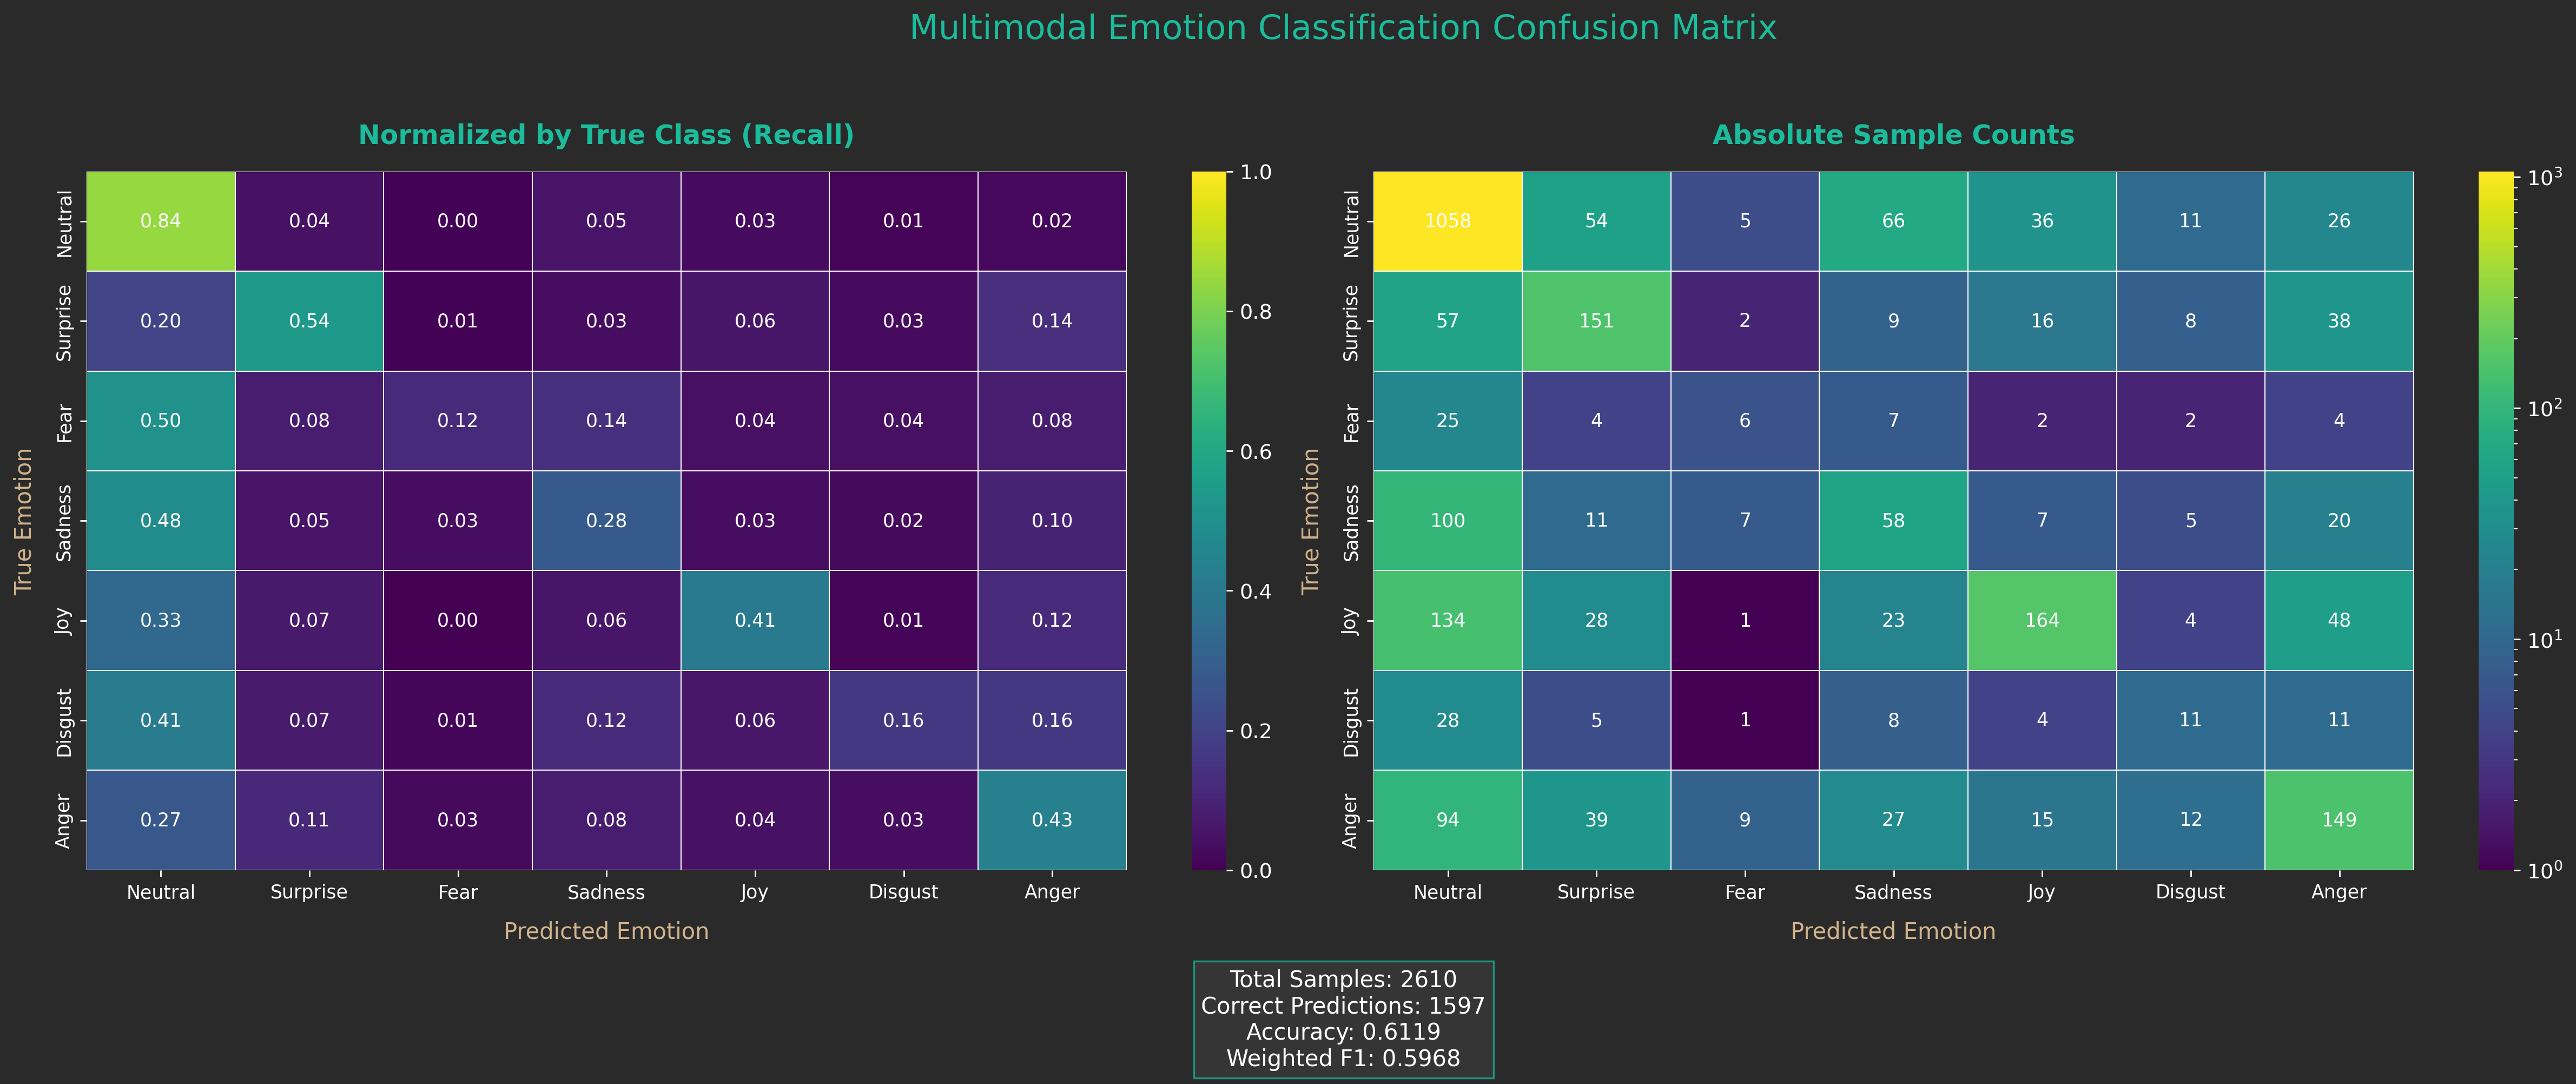

Saved confusion matrix to: confusion_matrix.png

Extracting BiLSTM features for all utterances...
Extracted features for 9988 utterances in train split
Extracted features for 1108 utterances in dev split
Extracted features for 2610 utterances in test split
Saved enhanced data with BiLSTM features to Enhanced_Features_with_BiLSTM.json


wandb:                                                                                
wandb: 
wandb: Run history:
wandb:      epoch ▁▁▂▂▂▃▃▃▃▄▄▄▅▅▅▆▆▆▆▇▇▇██
wandb:         lr ███████████████████▁▁▁▁▁
wandb:   test_acc ▁
wandb:    test_f1 ▁
wandb:  train_acc ▁▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇███
wandb:   train_f1 ▁▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇███
wandb: train_loss █▆▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▂▂▂▁▁▁
wandb:    val_acc ▁▄▆▇▇▇▅▇▇█▆█▇▇▆▇▆▆▆▅▆▅▅▆
wandb:     val_f1 ▁▅▅▇▇█▇▇▇███████▇▇▇▇▇▇▇▇
wandb:   val_loss ▅▃▃▂▂▁▂▁▂▂▁▂▁▁▂▂▃▄▅▅▆▇▇█
wandb: 
wandb: Run summary:
wandb:      epoch 24
wandb:         lr 0.00025
wandb:   test_acc 0.61188
wandb:    test_f1 0.59676
wandb:  train_acc 0.82279
wandb:   train_f1 0.82115
wandb: train_loss 0.37639
wandb:    val_acc 0.58303
wandb:     val_f1 0.55821
wandb:   val_loss 1.23158
wandb: 
wandb: 🚀 View run radiant-bush-29 at: https://wandb.ai/prakandabhandari-tribhuvan-university-institute-of-engin/Multimodal_Features_BiLSTM/runs/ab7p2yam
wandb: ⭐️ View project at: https://wandb.ai/prakandabhand

In [2]:
import random
import numpy as np
import torch
import json
import os
import shutil
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from sklearn.metrics import classification_report, f1_score, accuracy_score
from torch.optim.lr_scheduler import ReduceLROnPlateau
import wandb
from huggingface_hub import HfApi
from kaggle_secrets import UserSecretsClient
from collections import defaultdict
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import pickle
import re

# ========================================================================
# Enhanced Visualization Settings
# ========================================================================
BACKGROUND_COLOR = '#2A2A2A'
TEXT_COLOR = '#FFFFFF'
LABEL_COLOR = '#D2B48C'
TITLE_COLOR = "#1abc9c"

# Set global plotting parameters
plt.rcParams.update({
    'axes.facecolor': BACKGROUND_COLOR,
    'figure.facecolor': BACKGROUND_COLOR,
    'axes.edgecolor': TEXT_COLOR,
    'axes.labelcolor': LABEL_COLOR,
    'text.color': TEXT_COLOR,
    'xtick.color': TEXT_COLOR,
    'ytick.color': TEXT_COLOR,
    'grid.color': '#4A4A4A',
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.titleweight': 'bold',
    'axes.titlecolor': TITLE_COLOR,
    'axes.labelsize': 12,
    'figure.dpi': 250,
    'figure.autolayout': True
})

# ========================================================================
# Enhanced confusion matrix plotting function
# ========================================================================
def plot_styled_confusion_matrix(y_true, y_pred, class_names, title):
    # Convert to numpy arrays for element-wise operations
    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)

    """Create and display styled confusion matrix heatmap"""
    # Create subplots for both normalized and absolute counts
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8), facecolor=BACKGROUND_COLOR)
    fig.suptitle(title, color=TITLE_COLOR, fontsize=18, y=0.98)
    
    # Plot normalized confusion matrix (recall)
    cm_norm = confusion_matrix(y_true, y_pred, normalize='true')
    cm_norm_df = pd.DataFrame(cm_norm, index=class_names, columns=class_names)
    
    ax1.set_facecolor(BACKGROUND_COLOR)
    norm = mpl.colors.Normalize(vmin=0, vmax=1)
    sns.heatmap(
        cm_norm_df, 
        annot=True, 
        fmt='.2f', 
        cmap='viridis',
        linewidths=0.5,
        annot_kws={'color': TEXT_COLOR, 'size': 10},
        norm=norm,
        ax=ax1
    )
    ax1.set_title('Normalized by True Class (Recall)', color=TITLE_COLOR, fontsize=14, pad=15)
    ax1.set_xlabel('Predicted Emotion', color=LABEL_COLOR, fontsize=12, labelpad=10)
    ax1.set_ylabel('True Emotion', color=LABEL_COLOR, fontsize=12, labelpad=10)
    ax1.tick_params(axis='both', colors=TEXT_COLOR, labelsize=10)
    
    # Plot absolute counts confusion matrix
    cm_abs = confusion_matrix(y_true, y_pred)
    cm_abs_df = pd.DataFrame(cm_abs, index=class_names, columns=class_names)
    
    ax2.set_facecolor(BACKGROUND_COLOR)
    # Use logarithmic normalization for better visualization of large count ranges
    norm_abs = mpl.colors.LogNorm(vmin=1, vmax=cm_abs.max()) if cm_abs.max() > 0 else None
    sns.heatmap(
        cm_abs_df, 
        annot=True, 
        fmt='d',  # Integer format
        cmap='viridis',
        linewidths=0.5,
        annot_kws={'color': TEXT_COLOR, 'size': 10},
        norm=norm_abs,
        ax=ax2
    )
    ax2.set_title('Absolute Sample Counts', color=TITLE_COLOR, fontsize=14, pad=15)
    ax2.set_xlabel('Predicted Emotion', color=LABEL_COLOR, fontsize=12, labelpad=10)
    ax2.set_ylabel('True Emotion', color=LABEL_COLOR, fontsize=12, labelpad=10)
    ax2.tick_params(axis='both', colors=TEXT_COLOR, labelsize=10)
    
    # Add colorbar for absolute counts
    cbar = ax2.collections[0].colorbar
    cbar.ax.tick_params(colors=TEXT_COLOR)
    
    # Add statistics box
    total_samples = len(y_true_np)

    correct = np.sum(y_true_np == y_pred_np)

    accuracy = accuracy_score(y_true, y_pred)
    
    stats_text = (
        f"Total Samples: {total_samples}\n"
        f"Correct Predictions: {correct}\n"
        f"Accuracy: {accuracy:.4f}\n"
        f"Weighted F1: {f1_score(y_true, y_pred, average='weighted'):.4f}"
    )
    
    fig.text(
        0.5, 0.05, 
        stats_text,
        ha='center', va='center',
        fontsize=12, color=TEXT_COLOR,
        bbox=dict(facecolor='#3A3A3A', alpha=0.7, edgecolor='#1abc9c')
    )
    
    # Save and display
    plt.tight_layout(rect=[0, 0.1, 1, 0.95])  # Make space for stats box
    save_path = 'confusion_matrix.png'
    plt.savefig(save_path, dpi=250, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Saved confusion matrix to: {save_path}")
    
    return save_path

# -------------------------------
# Utility Functions
# -------------------------------

def set_seed(seed=42):
    random.seed(seed)                         # Python random module
    np.random.seed(seed)                      # NumPy
    torch.manual_seed(seed)                   # PyTorch CPU
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)              # PyTorch CUDA (single GPU)
        torch.cuda.manual_seed_all(seed)          # PyTorch CUDA (multi-GPU)
    
    torch.backends.cudnn.deterministic = True  # Makes CUDA deterministic
    torch.backends.cudnn.benchmark = False     # Disables auto-tuner for reproducibility 

def init_api_tokens():
    user_secrets = UserSecretsClient()
    return user_secrets.get_secret("HF_TOKEN"), user_secrets.get_secret("WANDB_API_KEY")

def init_wandb(wandb_token, config):
    wandb.login(key=wandb_token)
    wandb.init(project="Multimodal_Features_BiLSTM", config=config)
    
def init_hf_api(hf_token):
    return HfApi(token=hf_token)

def compute_class_weights_fn(labels):
    classes, counts = np.unique(labels, return_counts=True)
    weights = 1.0 / (counts + 1e-9)
    normalized_weights = weights / weights.sum() * len(classes)
    return torch.tensor(normalized_weights, dtype=torch.float32), counts

class AdaptiveFocalLoss(nn.Module):
    def __init__(self, gamma_base=2.0, class_counts=None, smoothing=0.1, alpha=0.8):
        super().__init__()
        self.gamma_base = gamma_base
        self.smoothing = smoothing
        self.alpha = alpha
        
        if class_counts is not None:
            weights = 1.0 / np.power(class_counts, 0.5)
            weights = np.maximum(weights, self.alpha * np.max(weights))
            normalized_weights = weights / weights.sum() * len(class_counts)
            self.register_buffer('gamma_weights', torch.tensor(normalized_weights, dtype=torch.float32))
        else:
            self.register_buffer('gamma_weights', torch.ones(7))

    def forward(self, inputs, targets):
        confidence = 1.0 - self.smoothing
        log_probs = F.log_softmax(inputs, dim=-1)
        nll_loss = -log_probs.gather(dim=-1, index=targets.unsqueeze(1)).squeeze(1)
        smooth_loss = -log_probs.mean(dim=-1)
        loss = confidence * nll_loss + self.smoothing * smooth_loss
        
        pt = torch.exp(-loss)
        gamma_weights = self.gamma_weights.to(targets.device)
        gamma = gamma_weights[targets] * self.gamma_base
        focal_loss = (1 - pt) ** gamma * loss
        return focal_loss.mean()

# -------------------------------
# Feature Extraction Components
# -------------------------------

class ModalityProjector(nn.Module):
    def __init__(self, input_dims, proj_dim=256):
        super().__init__()
        self.text_proj = nn.Sequential(
            nn.Linear(input_dims[0], proj_dim),
            nn.ReLU(),
            nn.LayerNorm(proj_dim))
        
        self.audio_proj = nn.Sequential(
            nn.Linear(input_dims[1], 512),
            nn.ReLU(),
            nn.Linear(512, proj_dim),
            nn.ReLU(),
            nn.LayerNorm(proj_dim))
        
        self.video_proj = nn.Sequential(
            nn.Linear(input_dims[2], 512),
            nn.ReLU(),
            nn.Linear(512, proj_dim),
            nn.ReLU(),
            nn.LayerNorm(proj_dim))
        
        self.gate = nn.Sequential(
            nn.Linear(proj_dim * 3, 3),
            nn.Softmax(dim=-1))

    def forward(self, x):
        text = x[..., :self.text_proj[0].in_features]
        audio = x[..., self.text_proj[0].in_features:self.text_proj[0].in_features+self.audio_proj[0].in_features]
        video = x[..., self.text_proj[0].in_features+self.audio_proj[0].in_features:]
        
        text_proj = self.text_proj(text)
        audio_proj = self.audio_proj(audio)
        video_proj = self.video_proj(video)
        
        combined = torch.cat([text_proj, audio_proj, video_proj], dim=-1)
        gate_weights = self.gate(combined.mean(dim=1, keepdim=True))
        
        text_gated = text_proj * gate_weights[:, :, 0:1]
        audio_gated = audio_proj * gate_weights[:, :, 1:2]
        video_gated = video_proj * gate_weights[:, :, 2:3]
        
        return torch.cat([text_gated, audio_gated, video_gated], dim=-1), gate_weights

# -------------------------------
# Model Architecture with Feature Extraction
# -------------------------------

class MultimodalBiLSTM(nn.Module):
    def __init__(self, input_dims, hidden_size, num_layers, output_size, dropout):
        super().__init__()
        self.projector = ModalityProjector(input_dims)
        self.input_norm = nn.LayerNorm(768)
        self.lstm = nn.LSTM(
            768, hidden_size, num_layers,
            batch_first=True, bidirectional=True, dropout=dropout
        )
        self.post_lstm_norm = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Sequential(
            nn.Dropout(dropout),
            nn.Linear(hidden_size * 2, output_size)
        )
        
        # Store features for external access
        self.contextual_features = None

    def forward(self, x, lengths):
        # Feature extraction
        projected, gate_weights = self.projector(x)
        x = self.input_norm(projected)
        packed_x = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        packed_out, _ = self.lstm(packed_x)
        lstm_out, _ = pad_packed_sequence(packed_out, batch_first=True)
        
        # Store contextual features before normalization
        self.contextual_features = lstm_out.detach().clone()
        
        # Continue processing
        lstm_out = self.post_lstm_norm(lstm_out)
        lstm_out = self.dropout(lstm_out)
        return self.fc(lstm_out), gate_weights
    
    def get_contextual_features(self, normalize=True):
        """Extract contextual features for GNN input"""
        if self.contextual_features is None:
            raise RuntimeError("No features available. Run forward pass first.")
        
        features = self.contextual_features
        if normalize:
            # Apply layer normalization
            mean = features.mean(dim=-1, keepdim=True)
            std = features.std(dim=-1, keepdim=True)
            features = (features - mean) / (std + 1e-9)
        return features

# -------------------------------
# Dataset and Training
# -------------------------------

class DialogueDataset(Dataset):
    def __init__(self, data, minority_classes=None, oversample_factor=2):
        self.dialogues = defaultdict(list)
        self.utterance_map = {}  # Maps utterance_id to (dialogue_id, index)
        
        for item in data:
            feature_key = next((k for k in item if k.endswith("_Concatenated")), None)
            if not feature_key:
                continue
                
            # Extract dialogue and utterance IDs
            dialogue_id, utt_id = feature_key.split("_")[:2]
            utterance_id = f"{dialogue_id}_{utt_id}"
            
            self.utterance_map[utterance_id] = item
            self.dialogues[dialogue_id].append((int(utt_id), item))
        
        self.dialogue_list = []
        for d_id, utterances in self.dialogues.items():
            utterances_sorted = sorted(utterances, key=lambda x: x[0])
            self.dialogue_list.append([item for _, item in utterances_sorted])
        
        if minority_classes:
            self._apply_utterance_oversampling(minority_classes, oversample_factor)
    
    def _apply_utterance_oversampling(self, minority_classes, factor):
        new_dialogues = []
        for dialogue in self.dialogue_list:
            new_dialogues.append(dialogue)
            minority_utterances = [
                (idx, item) for idx, item in enumerate(dialogue)
                if item['y'] in minority_classes
            ]
            for _ in range(factor):
                augmented = dialogue.copy()
                for pos, item in minority_utterances:
                    augmented.insert(pos + 1, item.copy())
                new_dialogues.append(augmented)
        self.dialogue_list = new_dialogues
    
    def __len__(self):
        return len(self.dialogue_list)
    
    def __getitem__(self, idx):
        dialogue = self.dialogue_list[idx]
        embeddings = []
        labels = []
        for item in dialogue:
            feature_key = next(k for k in item if k.endswith("_Concatenated"))
            emb = torch.tensor(item[feature_key], dtype=torch.float32)
            embeddings.append(emb)
            labels.append(torch.tensor(item["y"], dtype=torch.long))
        return torch.stack(embeddings), torch.stack(labels)

def dialogue_collate_fn(batch):
    dialogues, labels = zip(*batch)
    lengths = [d.shape[0] for d in dialogues]
    padded_dialogues = pad_sequence(dialogues, batch_first=True)
    padded_labels = pad_sequence(labels, batch_first=True, padding_value=-100)
    return padded_dialogues, padded_labels, lengths

def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0
    all_preds, all_labels = [], []
    
    for dialogues, labels, lengths in loader:
        dialogues, labels = dialogues.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs, _ = model(dialogues, lengths)
        outputs_flat = outputs.view(-1, outputs.shape[-1])
        labels_flat = labels.view(-1)
        valid_mask = labels_flat != -100
        
        if valid_mask.any():
            loss = criterion(outputs_flat[valid_mask], labels_flat[valid_mask])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            total_loss += loss.item()
            
            with torch.no_grad():
                preds = outputs_flat.argmax(dim=-1)
                all_preds.extend(preds[valid_mask].cpu().tolist())
                all_labels.extend(labels_flat[valid_mask].cpu().tolist())
    
    return total_loss / len(loader), all_preds, all_labels

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    all_preds, all_labels = [], []
    
    with torch.no_grad():
        for dialogues, labels, lengths in loader:
            dialogues, labels = dialogues.to(device), labels.to(device)
            outputs, _ = model(dialogues, lengths)
            outputs_flat = outputs.view(-1, outputs.shape[-1])
            labels_flat = labels.view(-1)
            valid_mask = labels_flat != -100
            
            if valid_mask.any():
                loss = criterion(outputs_flat[valid_mask], labels_flat[valid_mask])
                total_loss += loss.item()
                preds = outputs_flat.argmax(dim=-1)
                all_preds.extend(preds[valid_mask].cpu().tolist())
                all_labels.extend(labels_flat[valid_mask].cpu().tolist())
    
    return total_loss / len(loader), all_preds, all_labels

# -------------------------------
# Feature Extraction and Data Augmentation
# -------------------------------

def extract_and_store_features(model, dataset, device, data_dict, split, normalize=True):
    """Extract features and store them back in the original data structure"""
    model.eval()
    all_features = []
    
    # Create a loader that preserves dialogue order
    loader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=dialogue_collate_fn)
    
    with torch.no_grad():
        for batch_idx, (dialogues, labels, lengths) in enumerate(loader):
            dialogues, labels = dialogues.to(device), labels.to(device)
            
            # Forward pass to populate features
            _, _ = model(dialogues, lengths)
            
            # Get contextual features
            features = model.get_contextual_features(normalize=normalize)
            
            # Process each utterance in the dialogue
            for utt_idx in range(lengths[0]):
                # Get the original utterance ID
                dialogue_id = dataset.dialogue_list[batch_idx][utt_idx]['dialogue_id']
                utt_id = dataset.dialogue_list[batch_idx][utt_idx]['utt_id']
                utterance_key = f"{dialogue_id}_{utt_id}"
                
                # Find the corresponding item in the original data
                for item in data_dict[split]:
                    if f"{item['dialogue_id']}_{item['utt_id']}" == utterance_key:
                        # Create new key name by replacing 'Concatenated' with 'BiLSTM'
                        new_key = utterance_key + "_BiLSTM"
                        
                        # Convert to numpy and store
                        item[new_key] = features[0, utt_idx].cpu().numpy().tolist()
                        break
    
    print(f"Extracted features for {len(data_dict[split])} utterances in {split} split")
    return data_dict

# -------------------------------
# Main Training Routine
# -------------------------------

def main():
    set_seed(42)
    
    # Configuration
    config = {
        "architecture": "multimodal_bilstm",
        "max_epoch": 100,
        "batch_size": 16,
        "optimizer": "AdamW",
        "learning_rate": 0.0005,
        "gamma_base": 2.0,
        "weight_decay": 0.01,
        "hidden_size": 128,
        "num_layers": 2,
        "dropout": 0.5,
        "patience": 10,
        "modality_dims": [768, 6373, 2304]
    }
    
    # Initialize APIs
    hf_token, wandb_token = init_api_tokens()
    init_wandb(wandb_token, config)
    hf_api = init_hf_api(hf_token)
    
    # Load data
    with open("/kaggle/input/extracted-features/Enhanced_Combined_Features.json", "r") as f:
        original_data = json.load(f)
    
    # Preprocess: Add dialogue_id and utt_id to each item
    for split in ['train', 'dev', 'test']:
        for item in original_data[split]:
            # Extract dialogue and utterance IDs from keys
            for key in item:
                if key.endswith("_Concatenated"):
                    parts = key.split("_")
                    item["dialogue_id"] = parts[0]
                    item["utt_id"] = parts[1]
                    break

    # Define minority classes (Fear, Sadness, Disgust)
    minority_classes = [2, 3, 5]
    
    # Create datasets
    train_dataset = DialogueDataset(
        original_data["train"], 
        minority_classes=minority_classes,
        oversample_factor=2
    )
    dev_dataset = DialogueDataset(original_data["dev"])
    test_dataset = DialogueDataset(original_data["test"])
    
    # Create data loaders
    train_loader = DataLoader(train_dataset, batch_size=config["batch_size"], 
                             shuffle=True, collate_fn=dialogue_collate_fn)
    dev_loader = DataLoader(dev_dataset, batch_size=config["batch_size"], 
                           shuffle=False, collate_fn=dialogue_collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=config["batch_size"], 
                            shuffle=False, collate_fn=dialogue_collate_fn)
    
    # Initialize model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = MultimodalBiLSTM(
        input_dims=config["modality_dims"],
        hidden_size=config["hidden_size"],
        num_layers=config["num_layers"],
        output_size=7,
        dropout=config["dropout"]
    ).to(device)
    
    # Compute class weights BEFORE oversampling
    temp_dataset = DialogueDataset(original_data["train"], minority_classes=None)
    all_labels = []
    for _, labels in temp_dataset:
        all_labels.extend(labels.numpy().tolist())
    _, class_counts = compute_class_weights_fn(np.array(all_labels))
    
    # Loss function
    criterion = AdaptiveFocalLoss(
        gamma_base=config["gamma_base"],
        class_counts=class_counts,
        smoothing=0.1,
        alpha=0.8
    ).to(device)
    
    optimizer = optim.AdamW(
        model.parameters(), 
        lr=config["learning_rate"], 
        weight_decay=config["weight_decay"]
    )
    
    scheduler = ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, verbose=True
    )
    
    # Training loop
    best_val_f1 = 0.0
    epochs_no_improve = 0
    early_stop = False
    
    for epoch in range(config["max_epoch"]):
        if early_stop:
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
        
        # Training
        train_loss, train_preds, train_labels = train_one_epoch(
            model, train_loader, criterion, optimizer, device
        )
        train_f1 = f1_score(train_labels, train_preds, average='weighted')
        train_acc = accuracy_score(train_labels, train_preds)
        
        # Validation
        val_loss, val_preds, val_labels = validate(
            model, dev_loader, criterion, device
        )
        val_f1 = f1_score(val_labels, val_preds, average='weighted')
        val_acc = accuracy_score(val_labels, val_preds)
        
        # Update scheduler
        scheduler.step(val_f1)
        
        # Log metrics
        wandb.log({
            "epoch": epoch+1,
            "train_loss": train_loss,
            "train_acc": train_acc,
            "train_f1": train_f1,
            "val_loss": val_loss,
            "val_acc": val_acc,
            "val_f1": val_f1,
            "lr": optimizer.param_groups[0]['lr']
        })
        
        # Save best model
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            epochs_no_improve = 0
            torch.save(model.state_dict(), "best_model.pth")
            print(f"New best model at epoch {epoch+1} with val F1: {val_f1:.4f}")
        else:
            epochs_no_improve += 1
            print(f"No improvement for {epochs_no_improve}/{config['patience']} epochs")
            if epochs_no_improve >= config["patience"]:
                early_stop = True
    
    # Load best model for testing
    model.load_state_dict(torch.load("best_model.pth"))
    _, test_preds, test_labels = validate(model, test_loader, criterion, device)

    # Generate and log test report
    test_report = classification_report(test_labels, test_preds, digits=4)
    test_f1 = f1_score(test_labels, test_preds, average='weighted')
    test_acc = accuracy_score(test_labels, test_preds)
    
    print("\nTest Performance:")
    print(f"Accuracy: {test_acc:.4f}")
    print(f"Weighted F1: {test_f1:.4f}")
    print("Classification Report:")
    print(test_report)

    print("\n")

    label_map = {
        0: 'Neutral',
        1: 'Surprise',
        2: 'Fear',
        3: 'Sadness',
        4: 'Joy',
        5: 'Disgust',
        6: 'Anger'
    }
    
    # Create class names in the correct order (0-6)
    class_names = [label_map[i] for i in range(7)]
    
    # Generate styled confusion matrix with absolute counts
    cm_path = plot_styled_confusion_matrix(
        test_labels, 
        test_preds, 
        class_names,
        "Multimodal Emotion Classification Confusion Matrix"
    )
    
    # Parse report for WandB
    report_lines = test_report.split('\n')
    table_data = []
    for line in report_lines[2:-2]:
        if line.strip():
            parts = line.split()
            if len(parts) >= 5:
                table_data.append(parts[:5])
    
    wandb.log({
        "test_acc": test_acc,
        "test_f1": test_f1,
        "test_report": wandb.Table(
            columns=["Class", "Precision", "Recall", "F1-Score", "Support"],
            data=table_data
        ),
        "confusion_matrix": wandb.Image(cm_path)
    })
    
    # -------------------------------
    # Feature Extraction and Data Augmentation
    # -------------------------------
    print("\nExtracting BiLSTM features for all utterances...")
    
    # Extract features for each split
    original_data = extract_and_store_features(model, train_dataset, device, original_data, "train")
    original_data = extract_and_store_features(model, dev_dataset, device, original_data, "dev")
    original_data = extract_and_store_features(model, test_dataset, device, original_data, "test")
    
    # Save the enhanced data
    with open("Enhanced_Features_with_BiLSTM.json", "w") as f:
        json.dump(original_data, f, indent=2)
    
    print("Saved enhanced data with BiLSTM features to Enhanced_Features_with_BiLSTM.json")
    
    wandb.finish()

if __name__ == "__main__":
    main()